Họ và tên: Bùi Thị Yến Yến

MSSV: 20019721

# Helmet Detection by Yolov8

## Preparing environment and uploading data

The data can download on Kaggle [here](https://www.kaggle.com/datasets/andrewmvd/helmet-detection/data).



### Import packages

In [ ]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
import glob
import json
import cv2
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
! pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 9.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [33]:
from PIL import Image
import cv2

### Unzip data

In [4]:

! unzip '/content/drive/MyDrive/Colab Notebooks/data/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/data/helmet'


Archive:  /content/drive/MyDrive/Colab Notebooks/data/archive.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets0.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets1.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets10.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets100.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets101.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets102.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets103.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets104.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/helmet/annotations/BikesHelmets105.xml  
  inflating: /content/drive/MyDrive/Colab Notebooks/data/

## Converting XML to YOLO format

In [5]:

def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []
input_dir = "/content/drive/MyDrive/Colab Notebooks/data/helmet/annotations"
output_dir = "/content/drive/MyDrive/Colab Notebooks/data/helmet/labels"
image_dir = "/content/drive/MyDrive/Colab Notebooks/data/helmet/images"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

print("XML to YOLO Format Done!!")

XML to YOLO Format Done!!


## Drawing a bounding box

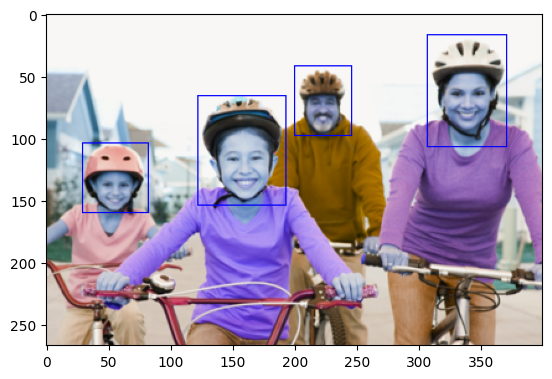

In [3]:

img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/helmet/images/BikesHelmets0.png")
dh, dw, _ = img.shape

fl = open("/content/drive/MyDrive/Colab Notebooks/data/helmet/labels/BikesHelmets0.txt", 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()

## Train Test Split

Train Set: 85%
Validation Set: 12.75%
Test Set: 2.25%

In [4]:

IMAGES_PATH = "/content/drive/MyDrive/Colab Notebooks/data/helmet/images"
LABELS_PATH = "/content/drive/MyDrive/Colab Notebooks/data/helmet/labels"

# Read labels
labels = os.listdir(LABELS_PATH)

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")

def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.png"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

print("Train Test Split Done!!")

train: 646; valid: 92; test: 23
Train Test Split Done!!


In [5]:

def get_image_size(image_path):
  with open(image_path, 'rb') as f:
    return f.read()

train_images_path = "/content/train/images"
valid_images_path = "/content/valid/images"
test_images_path = "/content/test/images"

train_images_sizes = [len(get_image_size(os.path.join(train_images_path, image))) for image in os.listdir(train_images_path)]
valid_images_sizes = [len(get_image_size(os.path.join(valid_images_path, image))) for image in os.listdir(valid_images_path)]
test_images_sizes = [len(get_image_size(os.path.join(test_images_path, image))) for image in os.listdir(test_images_path)]

print(f"Train images size: {sum(train_images_sizes)}")
print(f"Valid images size: {sum(valid_images_sizes)}")
print(f"Test images size: {sum(test_images_sizes)}")


Train images size: 344178482
Valid images size: 51141716
Test images size: 12427007


## Visualize the number of objects with and without helmets

In [6]:
# Get the path to the labels folder
labels_path = "/content/drive/MyDrive/Colab Notebooks/data/helmet/labels"

# Get a list of all the files in the labels folder
files = glob.glob(os.path.join(labels_path, "*.txt"))

# Initialize counters for objects with and without helmets
with_helmet = 0
without_helmet = 0

# Loop through each file
for file in files:
    # Open the file and read its contents
    with open(file, "r") as f:
        data = f.read()

    # Split the data into lines
    lines = data.split("\n")

    # Loop through each line
    for line in lines:
        # Split the line into words
        words = line.split(" ")

        # Check if the first word is "0" or "1"
        if words[0] == "0":
            without_helmet += 1
        elif words[0] == "1":
            with_helmet += 1

# Print the number of objects with and without helmets
print(f"Number of objects with helmet: {with_helmet}")
print(f"Number of objects without helmet: {without_helmet}")


Number of objects with helmet: 489
Number of objects without helmet: 962


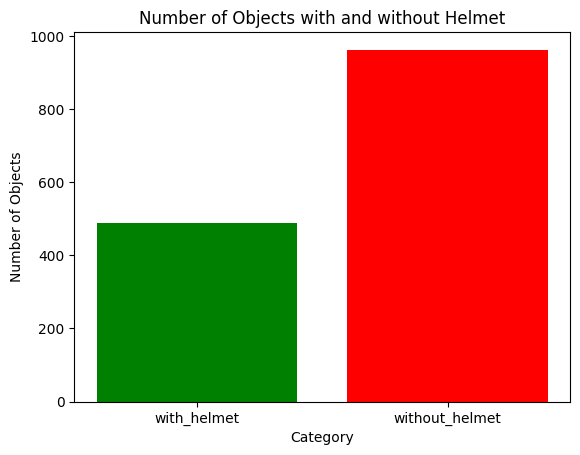

In [7]:
# Define the data
data = {'with_helmet': with_helmet, 'without_helmet': without_helmet}

# Define labels
labels = list(data.keys())

# Define values
values = list(data.values())

# Define colors
colors = ['g', 'r']

# Create a bar chart
plt.bar(labels, values, color=colors)

# Add title and axis labels
plt.title('Number of Objects with and without Helmet')
plt.xlabel('Category')
plt.ylabel('Number of Objects')

# Show the plot
plt.show()


## Training YOLO

In [10]:
model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 298MB/s]


### Training with epoch=16


In [11]:
# Train the model
model.train(data='/content/drive/MyDrive/Colab Notebooks/data/helmet/data.yaml', epochs=16)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Colab Notebooks/data/helmet/data.yaml, epochs=16, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 44.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 192MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 646 images, 0 backgrounds, 14 corrupt: 100%|██████████| 646/646 [00:00<00:00, 717.75it/s]

train: WARNING ⚠️ /content/train/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: WARNING ⚠️ /content/train/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: WARNING ⚠️ /content/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: WARNING ⚠️ /content/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: WARNING ⚠️ /content/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: WARNING ⚠️ /content/train/images/BikesHelmets343.png: ignoring corru

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 92 images, 0 backgrounds, 1 corrupt: 100%|██████████| 92/92 [00:00<00:00, 238.71it/s]

val: WARNING ⚠️ /content/valid/images/BikesHelmets706.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      379.5        82.5          61          65]
val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 16 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/16      6.82G      1.564      3.015      1.362         21        640: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         91        171      0.594      0.467      0.476      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/16      7.03G      1.437      1.306      1.238         34        640: 100%|██████████| 40/40 [00:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91        171      0.205      0.149     0.0545     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/16      7.07G      1.462      1.452      1.306         16        640: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         91        171   9.89e-05     0.0377   5.39e-05    1.4e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/16      7.06G      1.432      1.261      1.277         32        640: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         91        171      0.762      0.247      0.332      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/16      7.03G      1.438      1.185      1.275         36        640: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         91        171      0.587      0.376      0.373      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/16      7.02G      1.406      1.153      1.261         22        640: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         91        171      0.673      0.663      0.674      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/16      7.03G      1.389      1.105      1.289         17        640: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91        171      0.625      0.634      0.655      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/16      7.02G      1.378      1.071      1.291         12        640: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         91        171      0.604      0.683      0.637      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/16      7.03G       1.34     0.9914      1.274         17        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]

                   all         91        171      0.611      0.717      0.687      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/16      7.03G       1.31     0.9767      1.249         16        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         91        171       0.71      0.753      0.763      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/16      7.02G      1.313     0.9704      1.273         16        640: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         91        171      0.687      0.702      0.731      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/16      7.03G      1.268     0.8775      1.238         15        640: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         91        171      0.681      0.754      0.787      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/16      7.03G       1.26     0.8345      1.226         12        640: 100%|██████████| 40/40 [00:20<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         91        171      0.754      0.749      0.774      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/16      7.02G       1.23     0.7775      1.209         10        640: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         91        171      0.704      0.778      0.811      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/16      7.02G      1.224     0.7511      1.203         15        640: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         91        171      0.679      0.806      0.786      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/16      7.06G      1.179     0.7116      1.181          9        640: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         91        171      0.771      0.774      0.825      0.502



16 epochs completed in 0.117 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


                   all         91        171      0.769      0.773      0.825      0.501
           With Helmet         91        118       0.83      0.754      0.886      0.563
        Without Helmet         91         53      0.708      0.792      0.764       0.44
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe5a5eb3580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [12]:
# Save model
model.save('/content/drive/MyDrive/Colab Notebooks/data/helmet/model.pt')

#### Evaluate the model on the val set

In [13]:
results = model.val()
print(results)


Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/valid/labels.cache... 92 images, 0 backgrounds, 1 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/BikesHelmets706.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      379.5        82.5          61          65]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


                   all         91        171      0.766      0.768      0.828      0.504
           With Helmet         91        118      0.834      0.763      0.886      0.568
        Without Helmet         91         53      0.698      0.774       0.77      0.439
Speed: 0.3ms preprocess, 20.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe7188f03a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,   

### Test with the images


0: 640x640 2 With Helmets, 38.8ms
Speed: 3.9ms preprocess, 38.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'With Helmet', 1: 'Without Helmet'}
obb: None
orig_img: array([[[ 25,  34,  41],
        [ 26,  36,  42],
        [ 28,  38,  43],
        ...,
        [ 64,  88,  89],
        [ 63,  88,  90],
        [ 63,  88,  90]],

       [[ 22,  33,  39],
        [ 24,  35,  41],
        [ 26,  37,  42],
        ...,
        [ 61,  83,  86],
        [ 61,  84,  86],
        [ 61,  84,  86]],

       [[ 24,  35,  39],
        [ 24,  36,  40],
        [ 24,  37,  41],
        ...,
        [ 60,  80,  82],
        [ 58,  79,  81],
        [ 57,  78,  80]],

       ...,

       [[106, 115,  99],
        [109, 118, 102],
        [112, 122, 107],
        ...,
        [248, 247, 246],
        [248, 248, 247],
        [249, 248, 2

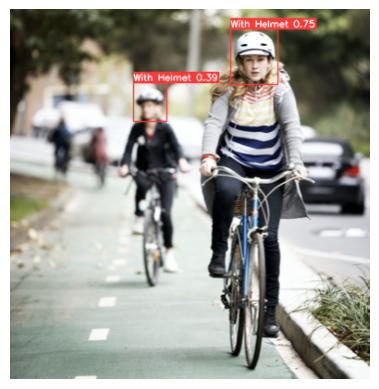

In [41]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/helmet/images/BikesHelmets102.png")
prediction = model.predict(img)[0]
print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)

plt.imshow(prediction)
plt.axis('off')
plt.show()

In [38]:
def detect_helmet(image_path):

  # Load the image
  img = cv2.imread(image_path)

  # Predict helmets in the image
  prediction = model.predict(img)[0]

  # Plot the predictions on the image
  prediction = prediction.plot(line_width=3)
  prediction = prediction[:, :, ::-1]
  prediction = Image.fromarray(prediction)

  # Display the image with bounding boxes
  plt.imshow(prediction)
  plt.axis('off')
  plt.show()



Enter the path to the image: /content/drive/MyDrive/Colab Notebooks/data/helmet/test.png

0: 480x640 4 With Helmets, 28.5ms
Speed: 4.3ms preprocess, 28.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


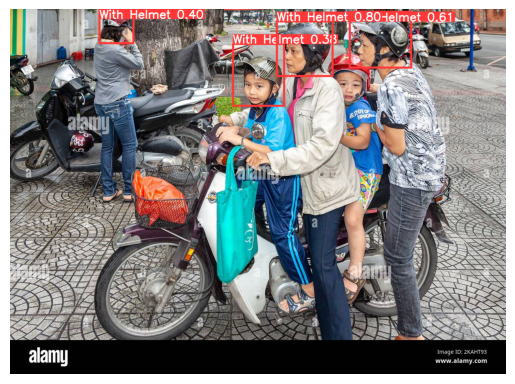

In [39]:
# Get the image path from the user
image_path = input("Enter the path to the image: ")

# Detect helmets in the image
detect_helmet(image_path)

### Continue training model with epochs= 14

In [47]:
# model = YOLO('/content/drive/MyDrive/Colab Notebooks/data/helmet/model.pt')

model.train(data='/content/drive/MyDrive/Colab Notebooks/data/helmet/data.yaml', epochs=14)

Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Colab Notebooks/data/helmet/data.yaml, epochs=14, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

train: Scanning /content/train/labels.cache... 646 images, 0 backgrounds, 14 corrupt: 100%|██████████| 646/646 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/train/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: WARNING ⚠️ /content/train/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: WARNING ⚠️ /content/train/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: WARNING ⚠️ /content/train/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: WARNING ⚠️ /content/train/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: WARNING ⚠️ /content/train/images/BikesHelmets343.png: ignoring corru


val: Scanning /content/valid/labels.cache... 92 images, 0 backgrounds, 1 corrupt: 100%|██████████| 92/92 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/BikesHelmets706.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      379.5        82.5          61          65]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 14 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/14      6.51G       1.42       1.94      1.404         14        640: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         91        171      0.616      0.561      0.614      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/14      7.13G      1.323      1.172      1.264         17        640: 100%|██████████| 40/40 [00:20<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         91        171      0.667       0.75      0.784      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/14      7.15G      1.295      1.098      1.257         10        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         91        171       0.67      0.756      0.781      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/14      7.14G      1.297      1.043      1.251         13        640: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         91        171      0.689      0.791      0.758      0.434


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/14      7.14G      1.295     0.9557      1.245         17        640: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         91        171      0.668      0.823      0.786      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/14      7.11G      1.271     0.9189      1.245         16        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         91        171      0.709       0.73      0.772      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/14      7.13G      1.257     0.8487      1.229         17        640: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         91        171      0.745      0.675      0.771      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/14      7.11G      1.239      0.869      1.223         14        640: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         91        171      0.723      0.802       0.79      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/14      7.12G       1.23     0.8224       1.22         17        640: 100%|██████████| 40/40 [00:21<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         91        171      0.716      0.834      0.834      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/14      7.14G      1.183     0.7694      1.193         14        640: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]

                   all         91        171      0.773      0.773      0.837      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/14      7.12G      1.177     0.7456      1.194         16        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         91        171      0.733      0.762       0.79      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/14       7.1G       1.17     0.7114      1.188         15        640: 100%|██████████| 40/40 [00:20<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         91        171      0.753      0.796      0.809      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/14      7.14G       1.13     0.6688      1.165         14        640: 100%|██████████| 40/40 [00:21<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         91        171      0.761      0.793      0.827      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/14      7.14G      1.106     0.6552      1.147         10        640: 100%|██████████| 40/40 [00:21<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         91        171      0.762      0.805      0.841      0.517



14 epochs completed in 0.104 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.24 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


                   all         91        171      0.781      0.795       0.84      0.517
           With Helmet         91        118      0.855      0.797      0.895      0.594
        Without Helmet         91         53      0.706      0.792      0.786       0.44
Speed: 0.2ms preprocess, 9.6ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe718aa8190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [48]:
# Save the updated model
model.save('/content/drive/MyDrive/Colab Notebooks/data/helmet/model_updated.pt')